### Practical Lab 8: K-means Clustering with cross-validation, and its application

*Some codes here are from from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas

This lab demonstrates:
* how to use cross-validation to select hyperparameter k for k-means clustering. 
* see example of advanced distance function for discovering non-linear boundaries (this example code will use scikit-learn)
* clustering for image compression



In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [51]:
# helper function:
# return index in input belonging to different classes
def decision(X,y):
    index_0 = (y == 0)
    index_1 = (y == 1)
    index_2 = (y == 2)
    index_3 = (y == 3)
    
    return X[index_0], X[index_1], X[index_2], X[index_3]
    

In [52]:

# Data generation
## generate random data from 4 different Gaussian distributions 
##(implicitly from 4 clusters)

# the number of data points for each cluster
n_samples = 100

# the Covariance for Gaussian distributions
C = np.array([[1.5, 3.1], [3.1, 1.5]])

# Generate the inputs randomly by Gaussian distribution with mean = 0 and covariance C
X1 =[4,5]+ np.dot(np.random.randn(n_samples, 2), C) 
X2 =[-4,-5]+ np.dot(np.random.randn(n_samples, 2), C)
X3 =[-5,5]+ np.dot(np.random.randn(n_samples, 2), C)
X4 =[5,-5]+ np.dot(np.random.randn(n_samples, 2), C)

# Just give the ground-truth labels (0,1,2,3)
# (Unsupervised-learning does not use)
Y1 =  np.ones(n_samples).reshape((n_samples,1))
Y2 =  2*np.ones(n_samples).reshape((n_samples,1))
Y3 =  3*np.ones(n_samples).reshape((n_samples,1))
Y4 =  np.zeros(n_samples).reshape((n_samples,1))

y = np.vstack([Y1,Y2,Y3,Y4]).flatten() # y collapsed into one dimension.
X = np.vstack([X1,X2,X3,X4])


print ("data.shape:", X.shape,y.shape)


data.shape: (400, 2) (400,)


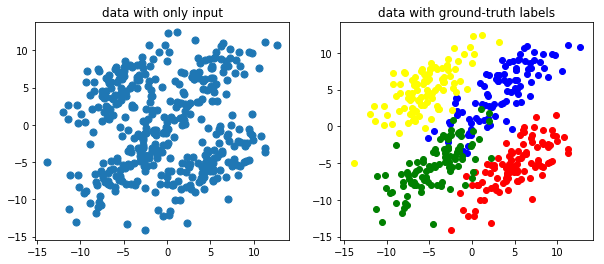

In [53]:
# Inspect the data

X1,X2,X3,X4 = decision(X,y)

# plotting only input data (supervised learning problem)
fig = plt.figure(figsize=(10, 4))
#fig, sub = plt.subplots(2, 1)
ax = fig.add_subplot(121) # the projection arg is important!
plt.scatter(X[:, 0], X[:, 1], s=50);
ax.set_title("data with only input")


ax1 = fig.add_subplot(122) # the projection arg is important!
ax1.scatter(X1[:, 0], X1[:, 1], color="red")
ax1.scatter(X2[:, 0], X2[:, 1], color="blue")
ax1.scatter(X3[:, 0], X3[:, 1], color="green")
ax1.scatter(X4[:, 0], X4[:, 1], color="yellow")
ax1.set_title("data with ground-truth labels")
plt.draw()


In [54]:

# Euclidean Distance Caculator
# Compute the distance from all X to all centroids
# the return distance are in size of (n_data,n_centroids)
def Euclidean_Distance(X_data, centroids):
        
    n_centres = centroids.shape[0]
    distances = []
    for c in range(n_centres):        
        distance_to_c = np.linalg.norm(X_data - centroids[c], axis=1)
        distances.append(distance_to_c)
    return np.array(distances).T

# computing the error function for clustering
## This is the within-cluster sum of square errors (SSE)
def computing_SSE(X, assignments, centroids):
    
    # initialize the within-cluster sum of square errors (SSE)
    SSE = 0
    n_centres = centroids.shape[0]
    
    for c in range(n_centres):  
        # extract only data points belong to centroid c
        X_c = X[assignments == c]   
        distance_to_c = np.linalg.norm(X_c - centroids[c], axis=1)
        distance_to_c = distance_to_c * distance_to_c
        SSE = SSE + np.sum(distance_to_c)       
        
    return SSE


In [55]:
# Main code for K-means clustering algorithm
# given input data, and the number of cluster to be discovered
# rseed is a random seed number
def find_clusters(X, n_clusters, rseed=100):
    # 1. Randomly choose clusters: pick a random data point to set as a centroid (try to pick n_clusters centroids)
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    # each centroid is put in one row of centroids
    centroids = X[i]
    
    iterations = 0    
    errors=[]
    
    while True:        
        # computing the distance from all data points to every centroid
        distances = Euclidean_Distance(X, centroids)
        
        # 1. Assign labels based on closest centroid. 
        assignments_index = np.argmin(distances,axis=1) 
                
        # 2. Find/update new centroids from means of points
        
        new_centroids = np.zeros(centroids.shape)        
        for i in range(n_clusters):
            # pick only rows that has assignment to class i
            new_centroids[i] = X[assignments_index == i].mean(0)        
        
        # 3. Check for convergence (if the centroid does not move)
        # we can also check the SSE (error)
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids
        
        iterations = iterations + 1
        # computing the SSE error for the current centroids/cluster
        SSE = computing_SSE(X, assignments_index, centroids)
        #print("iteration: ",iterations," the within-cluster square error is: ",SSE)
        errors.append(SSE)     
        
    
    return  centroids, assignments_index, errors


### 3. K-fold cross-validation:

(don't be confused with the parameters k in both k-fold and k-means methods. Their uses are different)
Let's use variable K_folds for K-fold and normal k for k-means.

- Using the SSE error to compare between K


In [56]:
# this is K_fold_cross_validation code
## inputs: 1. data; 2. the number of folds K_folds; 3. the number of cluster k (the value to be validated)
## 
def K_fold_cross_validation(data, K_folds, k):
    n_data = data.shape[0]
    
    # validation data's size
    test_size = int(n_data/K_folds)   
    
    #loop over k fold (each time leave one out to make a test set)  
    
    all_errors_test  = []
    all_errors_train = []
    for i in range(K_folds):
        X_test = data[test_size*i:test_size*(i+1),:]
        training_data  = data[0:test_size*i,:]
        X_training  = np.vstack((training_data,data[test_size*(i+1):,:]))
      
        
        #1. Clustering on training
        centroids, assignments, errors = find_clusters(X_training, k)        
        
       
        #################  ERROR COMPUTING  ############################
        #2. Computing error on the training dataset
        err_train = computing_SSE(X_training, assignments, centroids)
        
        #3. Computing error on the testing dataset
        ## 3.1 first compute the distance from test points to centroids
        distances = Euclidean_Distance(X_test, centroids)
        ## 3.2 assign test point to its closest centroid       
        assignments_test_data = np.argmin(distances,axis=1)  
        ## 3.3 compute the SSE for test points
        err_test = computing_SSE(X_test, assignments_test_data, centroids)
    
       
        
        # add this test/training error for computing statistics
        all_errors_test.append(err_test)
        all_errors_train.append(err_train)
        
        
    # returning the mean and standard deviation of the cross-validated errors
    return np.mean(all_errors_test), np.std(all_errors_test),np.mean(all_errors_train), np.std(all_errors_train)
    

In [57]:
K_folds = 3

num_candidates = 10
regular = np.zeros([num_candidates,5])

best_k = 0
best_SSE = 10000.

# loop over num_candidates possible candidates of lambda
for k in range(0,num_candidates): 
    number_centroids = k+1
    mean_test, std_test, mean_train, mean_std = K_fold_cross_validation(X,K_folds,number_centroids)
    
    regular[k,0] = k
    regular[k,1:] = mean_test, std_test, mean_train, mean_std
    
    if best_SSE > mean_test:
        best_SSE = mean_test
        best_k = k


best lamda =  9
best best_SSE =  986.745186213863


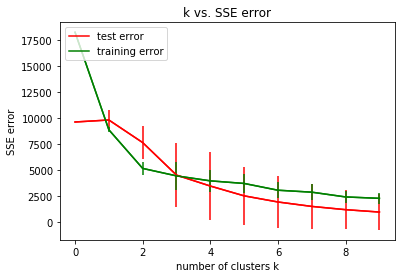

In [58]:
# PLOTTING



fig = plt.figure()
fig = fig.add_subplot(1, 1, 1) 
plt.plot(np.arange(num_candidates),regular[:,1],'red',label="test error")
plt.plot(np.arange(num_candidates),regular[:,3],'green',label="training error")

# plotting the error bars (with standard deviations)
plt.errorbar(np.arange(num_candidates),regular[:,1], yerr=regular[:,2], color='red')
plt.errorbar(np.arange(num_candidates),regular[:,3], yerr=regular[:,4], color='green')

plt.title("k vs. SSE error")
plt.legend(loc='upper left')
plt.xlabel('number of clusters k')
plt.ylabel('SSE error')
plt.draw()

print('best lamda = ',best_k)
print('best best_SSE = ',best_SSE)

### 4. K-means for non-linear cluster boundaries
k-means is limited to linear cluster boundaries. The fundamental model assumptions of *k*-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between *k*-means clusters will always be linear, which means that it will fail for more complicated boundaries.
Consider the following data, along with the cluster labels found by the typical *k*-means approach:

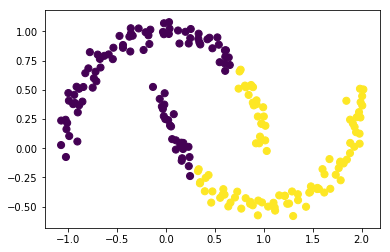

In [59]:

from sklearn.datasets import make_moons

"""
Make two interleaving half circles
"""
X, y = make_moons(200, noise=.05, random_state=0)

## K-means with Eucliean distance
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

One version of non-linear *k*-means is implemented in Scikit-Learn within the ``SpectralClustering`` estimator.
It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a *k*-means algorithm:


Read this paper for the method SpectralClustering
[1] http://people.csail.mit.edu/dsontag/courses/ml14/notes/Luxburg07_tutorial_spectral_clustering.pdf

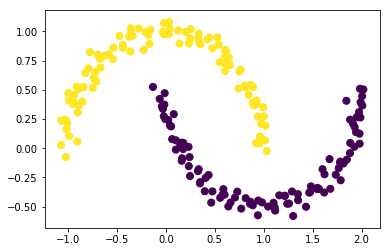

In [60]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

### 5. Application of Clustering for Image Compression/Color Quantization
One interesting application of clustering is in color compression within images.
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.



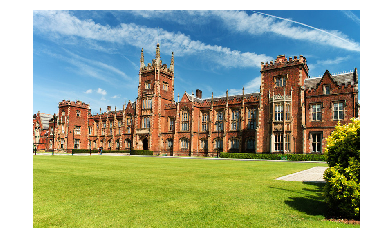

In [61]:
# load the image in file "qub.jpg"
image = plt.imread("qub.jpg")


fig, ax = plt.subplots()
im = ax.imshow(image)

ax.axis('off')
plt.show()

In [62]:
# print image size
size_img = image.shape
print(size_img)

(533, 800, 3)


One way we can view this set of pixels is as a cloud of points in a three-dimensional color space.
We will reshape the data to ``[n_samples x n_features]``, and rescale the colors so that they lie between 0 and 1:

In [63]:
# 255 is the maximum value of R, G, B
data = image / 255.0 # use 0...1 scale/normalize the image
data = data.reshape(size_img[0] * size_img[1], size_img[2])
data.shape

(426400, 3)

We can visualize these pixels in this color space, using a subset of 10,000 pixels for efficiency:

In [64]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset (N pixels)
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

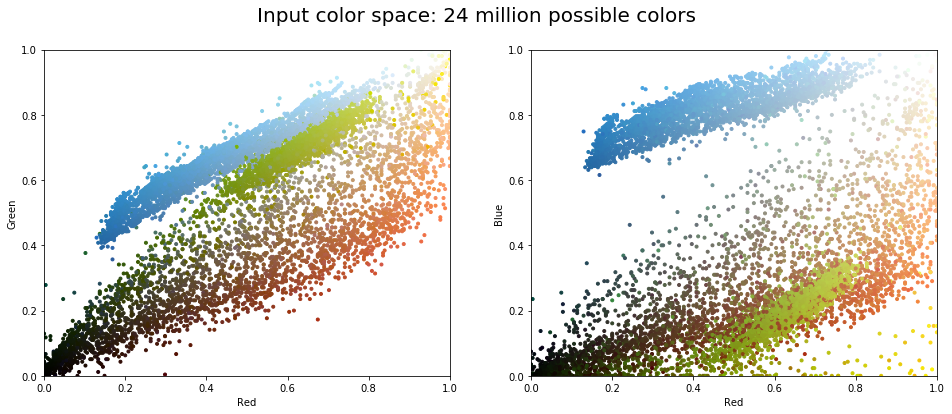

In [65]:
plot_pixels(data, title='Input color space: 24 million possible colors')

Now let's reduce these 24 million colors to just 16 colors, using a *k*-means clustering across the pixel space.
Because we are dealing with a very large dataset, we will use the mini batch *k*-means, which operates on subsets of the data to compute the result much more quickly than the standard *k*-means algorithm:

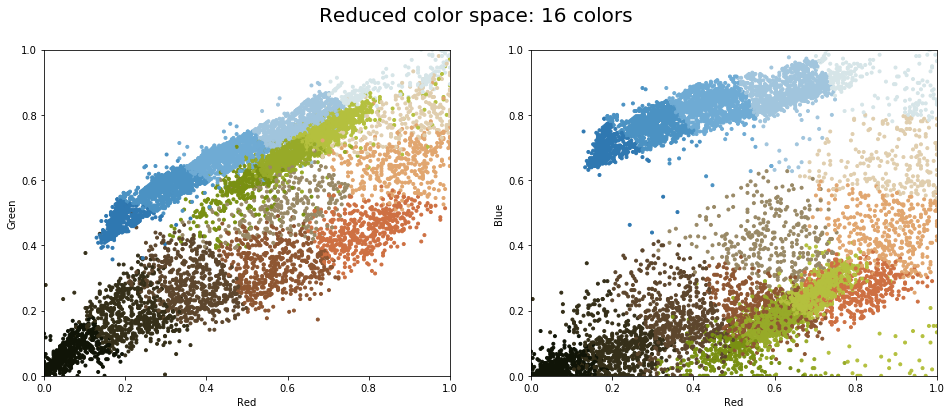

In [66]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)] # assign pixel color to its centroid's color

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

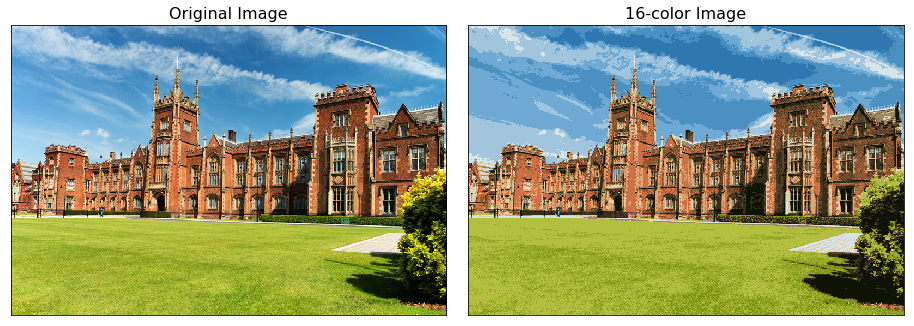

In [67]:
def plot_images(new_image, title2):
    

    fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(wspace=0.05)
    ax[0].imshow(image)
    ax[0].set_title('Original Image', size=16)
    ax[1].imshow(new_image)
    ax[1].set_title(title2, size=16);
    
image_recolored = new_colors.reshape(image.shape)
plot_images(image_recolored,'16-color Image')

### 6. Image compression/color quantization using code from scratch
this code is without sciki-learn

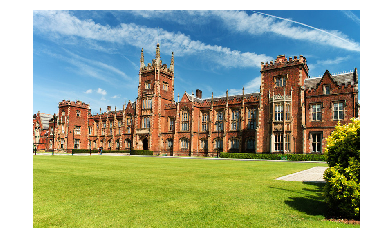

(426400, 3)

In [68]:
image = plt.imread("qub.jpg")

fig, ax = plt.subplots()
im = ax.imshow(image)

ax.axis('off')
plt.show()

size_img = image.shape
data = image / 255.0 # use 0...1 scale/normalize the image
data = data.reshape(size_img[0] * size_img[1], size_img[2])
data.shape

In [69]:
print(data.shape)
number_of_clusters = 16
# use the code developed previously from scratch
centroids, assignments, errors = find_clusters(data, number_of_clusters)


(426400, 3)


In [70]:
print(assignments.shape)
print(centroids.shape)

# create a new image with compressed colors
new_image_data = np.copy (data)
for i in range(number_of_clusters):
    new_image_data[assignments == i] = centroids[i]  # assign pixel color to its centroid's color
    

(426400,)
(16, 3)


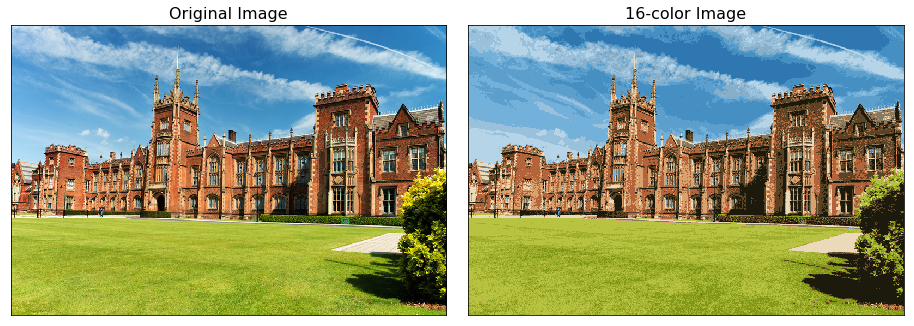

In [71]:
new_image_data = new_image_data.reshape(image.shape)
plot_images(new_image_data, '16-color Image')
